
# Балістичний калькулятор

Розглянемо 7-дюймовий дрон, який несе бімбу. Його положення в просторі визначається двома параметрами $(A, t)$, де $A$ — базис системи координат дрона, $t$ — паралельне зміщення відносно початку координат. Відповідно, ми можемо розглянути дві системи координат:

1. __Глобальна система__ координат $(lat, lon, alt)$ — довгота, широта, висота. Довготу і широту можна перевести в метри відносно якоїсь стартової точки, використовуючи _haversine distance_. Стартова точка і є початком координат $(0, 0, 0)$.
2. __Локальна система__ координат дрона. Зазвичай обирають $(х, у, z)$ так, щоб вісь х дивилась вперед, у вправо, а z вниз (див. малюнок).

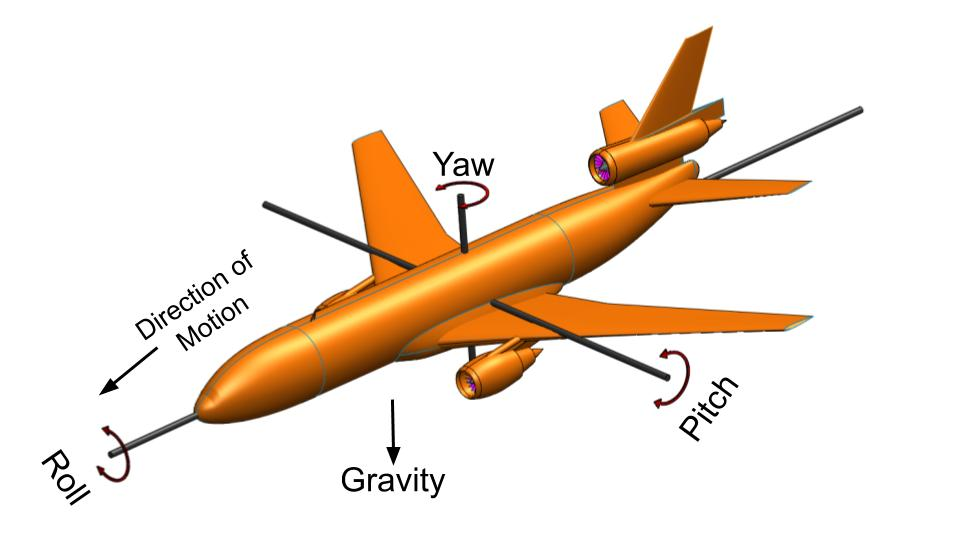

Таким чином $А$ — це матриця переходу від глобального базису до локального базису дрона, а $t$ — це вектор зміщення з початку координат. Ця матриця є матрицею поворота, яку можна представити за допомогою 3-х кутів ейлера: _roll, pitch, yaw_, які означають повороти відносно осей х, у, z відповідно. Глобальною системою координат часто обирають NED — North East Down. Тобто якщо дрон висить паралельно поверхні землі, дивлячись на північ, то його положення буде $(0, 0, 0)$. Якщо ж дивиться на схід, трохи нахилившись вперед, то $(0, \pi/8, \pi/2)$

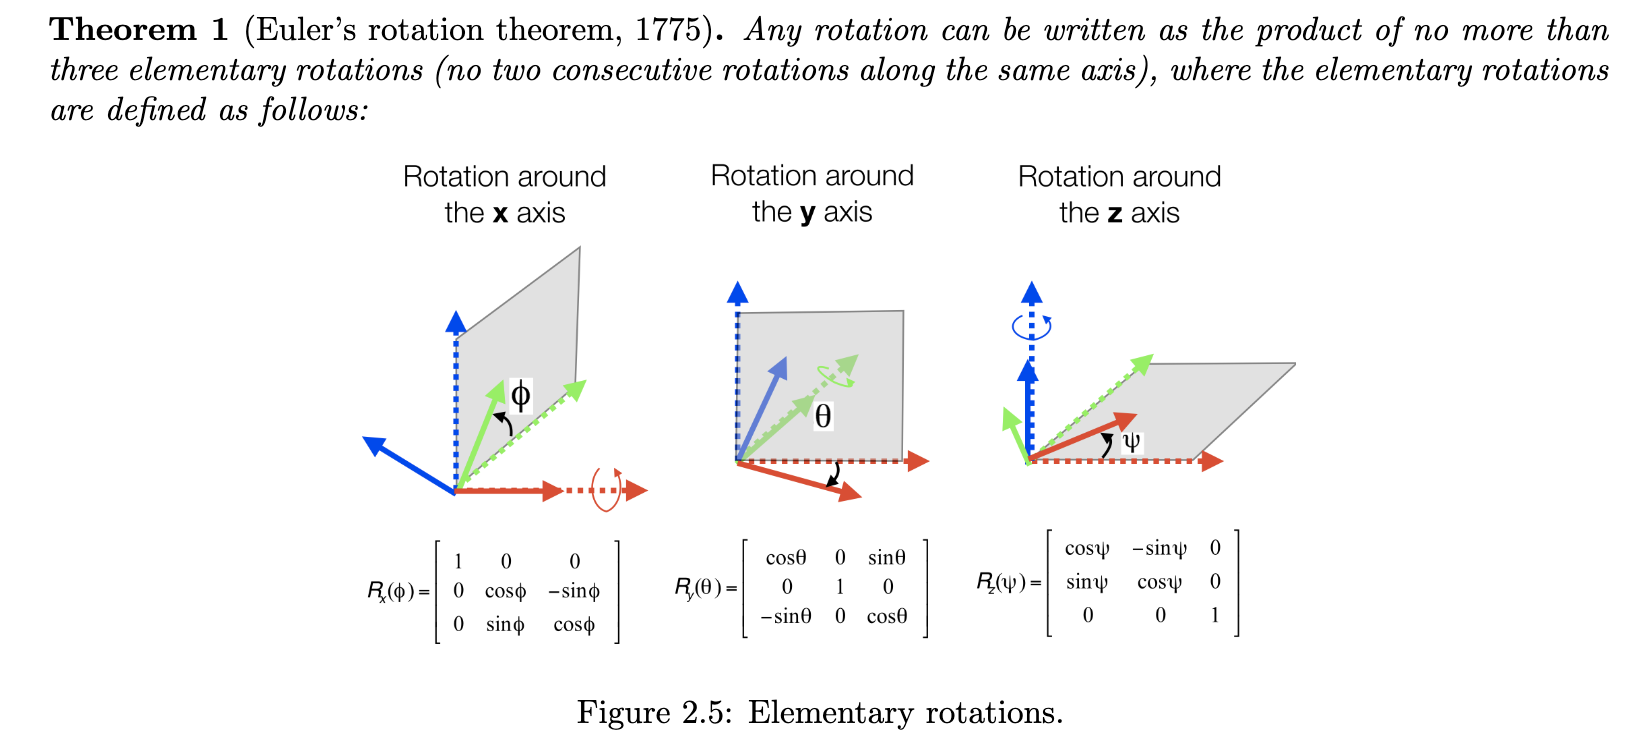



### Дано:

 - положення дрона в просторі __в глобальній системі координат NED__ відносно деякої стартової точки, а саме 3 кути ейлера _(roll, pitch, yaw)_, та абсолютне положення _(х, у, z)_ в метрах.
 - вектор швидкості $\bar{v} = (v_x, v_y, v_z)$ __в локальній системі координат__, при чому $|v|$ -- миттєва швидкість. Наприклад, (1, 0, 0) означає, що дрон летить строго вперед з швидкістю 1м/c.
 - вектор швидкості вітру $\bar{u} = (u_x, u_y, u_z)$ __в локальній системі координат__, при чому $|u|$ -- миттєва швидкість. Наприклад, (0, 0.1, 0) означає, що вітер дме вправо зі швидкістю 0.1 м/c.

### Завдання: 

Необхідно розрахувати і намалювати траекторію польоту бімби. Вважати, що бімба -- це точкове тіло, на яке вітер і гравітація впливають без втрат. Вітер дме з постійними швидкістю і напрямом. 

### Вказівки: 

Траекторію можна намалювати, використовуючи `tkinter.canvas`, як проекції на три площини (як у кресленні).

Всі параметри мають задаватись користувачем у відповідні поля графічного інтерфейсу. 

# Додатково

Розглянемо бібліотеку для роботи з компʼютерним зором `opencv`. Її можна встановити командою 
```bash 
pip install opencv-python
```

Ця бібліотека неймовірно велика і потужна, та, поміж іншого, вона дозволяє малювати на картинках.

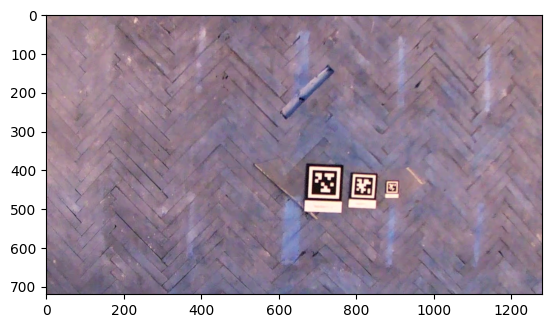

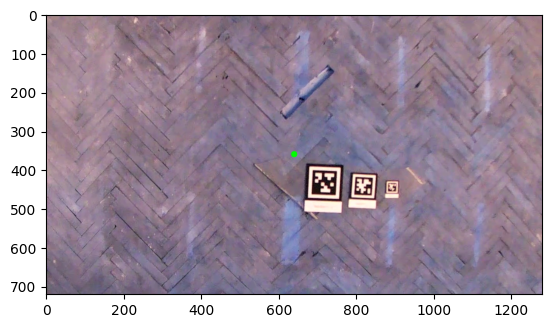

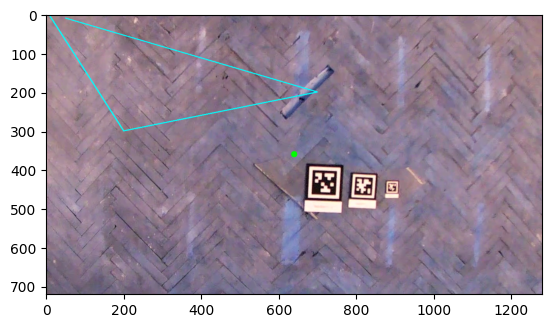

In [13]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 


# читаємо зображення. Img -- це тривимірний нумпай масив (h, w, ch), 
# тобто це матриця, де в кожній клітинці знаходиться колір -- трійка (R, G, B)
img = cv2.imread('image_1668.png')

# один з можливих варіантів вивести зображення -- матплотліб
plt.imshow(img)
plt.show()

h, w, channels = img.shape

# можна намалювати круг (а.к.а. точку)
img = cv2.circle(img, (int(w/2), + int(h/2)), radius=8,
                 color=(0, 255, 0), thickness=-1)
plt.imshow(img)
plt.show()

# можна намалювати ламану
pts = np.array([[[10,5],[200,300],[700,200],[50,10]]], np.int32)
img = cv2.polylines(img, pts, isClosed=False, color=(0,255,255), thickness=2)
plt.imshow(img)
plt.show()

Основне, для чого нам знадобиться OpenCV -- проектування 3д координат точки на зображення. Для цього нам знадобиться так звана __калібрувальна матриця__ $K$.

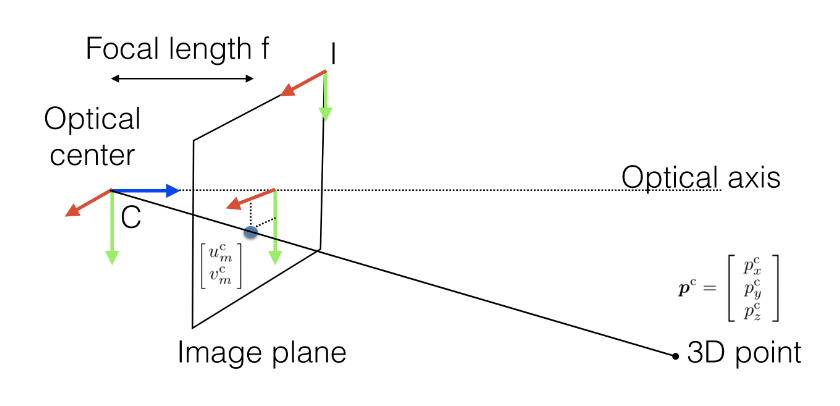

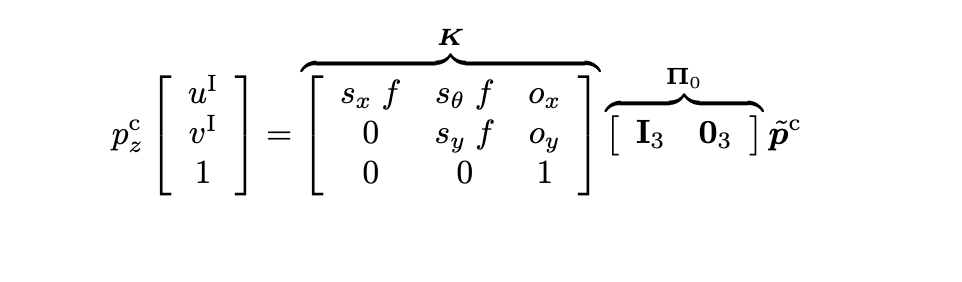

Тут $p^c$ -- координати точки відносно системи координат камери, а $(u^c_x, u^x_y)$ -- координати цієї ж точки в пікселях. Система координат камери визначається трохи по-іншому, ніж система координат дрона: 

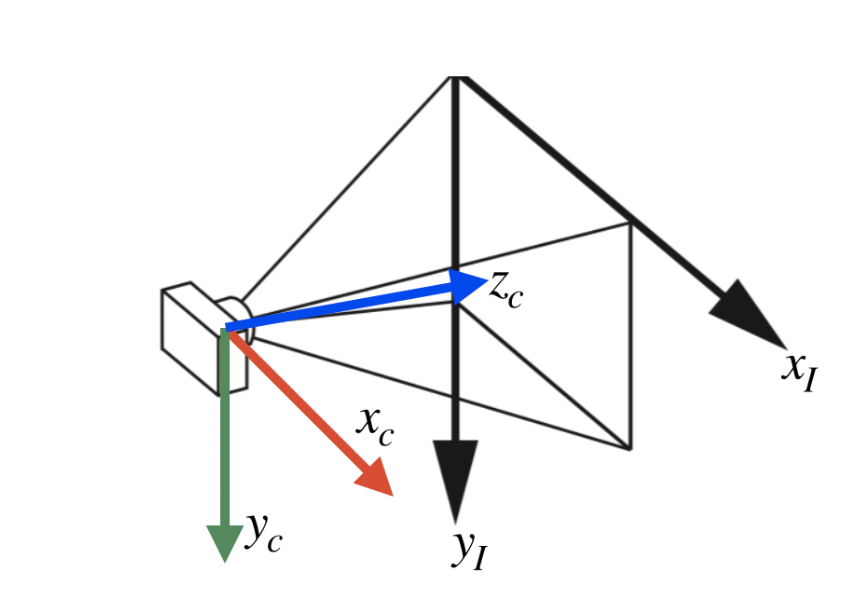

Простими словами, калібрувальна матриця задає фокусну відстань і дозволяє переходити з координат на картинці до координат у світі і навпаки. Окрім калібрувальної матриці треба ще вектор викривлення, оскільки камери часто спотворюють зображення на межі. Маючи їх, OpenCV дозволить нам намалювати траекторію прям на зображенні. 


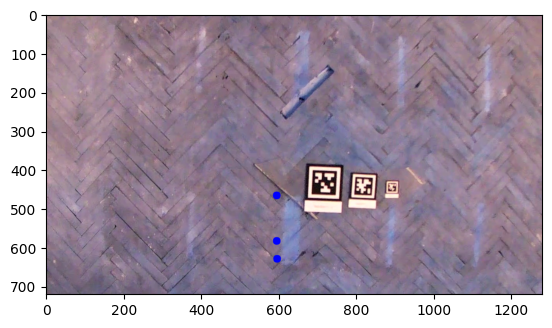

In [47]:

camera_matrix = np.matrix([
    [1755.4404327456236, 0.0, 595.6112275444069],
    [0.0, 1749.757170404926, 260.79397620261625],
    [0.0, 0.0, 1.0]
], dtype=float)

distortion = np.matrix([-0.5764957531612058,
                        0.1442663511843776,
                        0.016044965988848164,
                        0.005708590283968032,
                        0.9749205574691415])

# це матриця повороту і вектор зміщення для камери. Вони нам не потрібні, тому тривіальні
rvec = np.eye(3)
tvec = np.array([[0, 0, 0]], dtype=float)

# координати (х,у,z) відносно центру зображення, де z -- це глибина
object_points = np.array([[0, 3, 14], [0, 2.8, 15], [0, 2, 17]], dtype=float)

# спро
t_arr, _ = cv2.projectPoints(object_points, rvec, tvec, camera_matrix, distortion)

img = cv2.imread('image_1668.png')

for t in t_arr:
    t = t.flatten()
    img = cv2.circle(img, center=(int(t[0]), int(t[1])), radius=10,
                     color=(0, 0, 255), thickness=-1)
plt.imshow(img)
plt.show()

In [44]:
t_arr

array([[[597.02044335, 879.25328058]],

       [[596.5811701 , 784.15663682]],

       [[596.23754568, 688.08655736]]])

In [28]:
t

array([613.1732496, 278.3027582])